<a href="https://colab.research.google.com/github/Hasnulsanna/Main_project/blob/main/Lipreading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [107]:
%cd drive/MyDrive

[Errno 2] No such file or directory: 'drive/MyDrive'
/content/drive/MyDrive


In [108]:
#!unzip data.zip
#%ls

In [109]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [110]:
tf.config.list_physical_devices('GPU')

[]

In [111]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass


In [112]:
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [113]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [114]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [115]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [116]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11])>

In [117]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [132]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    # File name splitting for windows
    # file_name = path.split('\\')[-1].split('.')[0]
    file_name = os.path.splitext(os.path.basename(path))[0]
    video_path = os.path.join('/content/drive/MyDrive/data/s1', f'{file_name}.mpg')
    # Construct alignment file path with the correct extension or naming convention
    alignment_path = os.path.join('/content/drive/MyDrive/data/alignments/s1', f'{file_name}.align')

    print(f"Video path: {video_path}")
    print(f"Alignment path: {alignment_path}")

    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments


In [133]:
# test_path = '.\\data\\s1\\bbbf4s.mpg'

In [137]:
test_path = '/content/drive/MyDrive/data/s1/bbbf4s.mpg'

In [138]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'/content/drive/MyDrive/data/s1/bbbf4s'

In [139]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

Video path: /content/drive/MyDrive/data/s1/bbbf4s.mpg
Alignment path: /content/drive/MyDrive/data/alignments/s1/bbbf4s.align


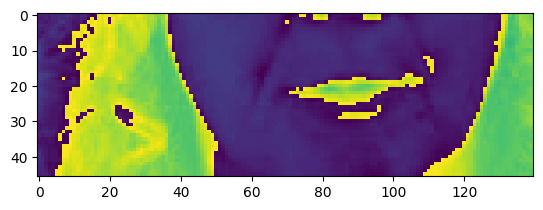

In [140]:
plt.imshow(frames[40])

In [141]:
alignments

<tf.Tensor: shape=(23,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  2, 25, 39,  6, 39,  6, 15, 21,
       18, 39, 19, 15, 15, 14])>

In [142]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue by f four soon'>

In [143]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

In [144]:
from matplotlib import pyplot as plt

In [145]:
data = tf.data.Dataset.list_files('/content/drive/MyDrive/data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split
train = data.take(450)
test = data.skip(450)

In [128]:
# for file_path in data:
#     print(file_path.numpy().decode('utf-8'))

In [129]:
len(train)

450

In [130]:
len(test)

4200

In [146]:
frames, alignments = data.as_numpy_iterator().next()

Video path: /content/drive/MyDrive/data/s1/bbbj1p.mpg
Alignment path: /content/drive/MyDrive/data/alignments/s1/bbbj1p.align
Video path: /content/drive/MyDrive/data/s1/lbio7s.mpg
Alignment path: /content/drive/MyDrive/data/alignments/s1/lbio7s.align


In [147]:
len(frames)

2

In [148]:
sample = data.as_numpy_iterator()

In [149]:
val = sample.next(); val[0]

Video path: /content/drive/MyDrive/data/s1/bgiq6n.mpg
Alignment path: /content/drive/MyDrive/data/alignments/s1/bgiq6n.align
Video path: /content/drive/MyDrive/data/s1/brav7s.mpg
Alignment path: /content/drive/MyDrive/data/alignments/s1/brav7s.align
Video path: /content/drive/MyDrive/data/s1/bwae7n.mpg
Alignment path: /content/drive/MyDrive/data/alignments/s1/bwae7n.align


array([[[[[1.4712046 ],
          [1.4712046 ],
          [1.4712046 ],
          ...,
          [0.0576943 ],
          [0.0576943 ],
          [0.0576943 ]],

         [[1.4712046 ],
          [1.4712046 ],
          [1.4712046 ],
          ...,
          [0.0576943 ],
          [0.0576943 ],
          [0.11538859]],

         [[1.4423574 ],
          [1.4423574 ],
          [1.4423574 ],
          ...,
          [0.11538859],
          [0.11538859],
          [0.14423575]],

         ...,

         [[1.2692746 ],
          [1.3269689 ],
          [1.3269689 ],
          ...,
          [5.827124  ],
          [5.5674996 ],
          [5.3655696 ]],

         [[1.2115803 ],
          [1.2692746 ],
          [1.2404274 ],
          ...,
          [5.740583  ],
          [5.596347  ],
          [5.394417  ]],

         [[1.2115803 ],
          [1.2692746 ],
          [1.2404274 ],
          ...,
          [5.740583  ],
          [5.6540413 ],
          [5.423264  ]]],


        [[[1.4135

In [150]:
fv = (val[0][1].astype(np.uint8) * 255).squeeze()
imageio.mimsave('./animation.gif', fv, duration=100)

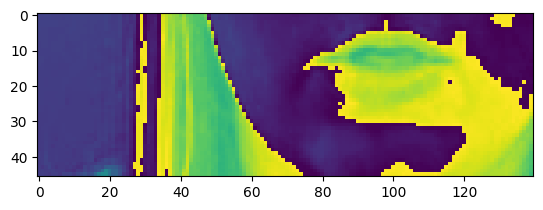

In [151]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video
plt.imshow(val[0][0][35])

In [152]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin green in q six now'>

In [153]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler


In [154]:
data.as_numpy_iterator().next()[0][0].shape

Video path: /content/drive/MyDrive/data/s1/lbij6n.mpg
Alignment path: /content/drive/MyDrive/data/alignments/s1/lbij6n.align
Video path: /content/drive/MyDrive/data/s1/bbwz7a.mpg
Alignment path: /content/drive/MyDrive/data/alignments/s1/bbwz7a.align
Video path: /content/drive/MyDrive/data/s1/bgwn2a.mpg
Alignment path: /content/drive/MyDrive/data/alignments/s1/bgwn2a.align


(75, 46, 140, 1)

In [155]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [156]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

In [157]:
5*17*75

6375

In [158]:
yhat = model.predict(val[0])

1/1 [==============================] - 14s 14s/step


In [159]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b'44444kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkjjjjjjjjjjjjjjjjwww'>

In [160]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'44444kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkjjjjjjjjjjjjjjjjwww'>

In [161]:
model.input_shape

(None, 75, 46, 140, 1)

In [162]:
model.output_shape

(None, 75, 41)

In [163]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [164]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [165]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [166]:
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), loss=CTCLoss)

In [167]:
checkpoint_callback = ModelCheckpoint('models/checkpoint', monitor='loss', save_weights_only=True)

In [168]:
schedule_callback = LearningRateScheduler(scheduler)

In [169]:
example_callback = ProduceExample(test)


In [ ]:
#model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])